<a href="https://colab.research.google.com/github/PengpeiZhu/IDL_Assignment-1/blob/main/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Create Dataset from JPEG

The dataset are downloaded from https://www.kaggle.com/datasets/splcher/animefacedataset, origionally made by https://github.com/bchao1/Anime-Face-Dataset.

In [ ]:
# Step 1: Get all jpg image files in the dataset folder
image_files = [f for f in os.listdir("anime_faces_dataset/") if f.endswith(".jpg")]

# Placeholder list to hold processed images
images_list = []

for image_file in image_files:
    # Step 2a: Load the image using PIL
    img_path = os.path.join("anime_faces_dataset/", image_file)
    with Image.open(img_path) as img:
        # Step 2b: Resize the image to 64x64
        img_resized = img.resize((64, 64))

        # Convert image to numpy array
        img_array = np.array(img_resized)

        # Step 2c: Rescale the image (normalize pixel values to [0, 1])
        # img_rescaled = img_array / 255.0

        images_list.append(img_array)

# Step 3: Stack all processed images into a single numpy array
dataset = np.stack(images_list, axis=0)

# Step 4: Save the numpy array to a ".npy" file
np.save("anime_faces.npy", dataset)

FileNotFoundError: ignored

## Read Dataset

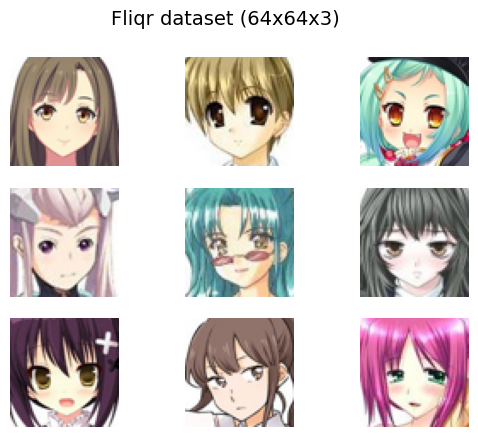

In [2]:
def load_real_samples(scale=False):
    # We load 10,000 samples only to avoid memory issues, you can  change this value
    X = np.load("drive/MyDrive/anime_faces.npy")[:10000, :, :, :]
    # Scale samples in range [-127, 127]
    if scale:
        X = (X - 127.5) * 2
    return X / 255.0


# We will use this function to display the output of our models throughout this notebook
def grid_plot(
    images,
    epoch="",
    name="",
    n=3,
    save=False,
    scale=False,
    method="",
    figtype="generated",
    show = True,
):
    if scale:
        images = (images + 1) / 2.0
    for index in range(n * n):
        plt.subplot(n, n, 1 + index)
        plt.axis("off")
        plt.imshow(images[index])
    fig = plt.gcf()
    fig.suptitle(name + "  " + str(epoch), fontsize=14)
    if save:
        filedir = f"drive/MyDrive/{method}_generated_figures/"
        if figtype == "generated":
            filename = "generated_figure_e%03d_f.png" % (epoch + 1)
        elif figtype == "original":
            filename = "origional_figure_e%03d_f.png" % (epoch + 1)
        plt.savefig(filedir + filename)
        plt.close()
    if show:
      plt.show()


dataset = load_real_samples()
grid_plot(dataset[np.random.randint(0, 1000, 9)], name="Fliqr dataset (64x64x3)", n=3)

## Code for building Down/Up sampling

In [3]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape


def build_conv_net(
    in_shape, out_shape, n_downsampling_layers=4, filters=128, out_activation="sigmoid"
):
    """
    Build a basic convolutional network
    """
    model = tf.keras.Sequential()
    default_args = dict(
        kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu"
    )

    model.add(Conv2D(input_shape=in_shape, **default_args, filters=filters))

    for _ in range(n_downsampling_layers):
        model.add(Conv2D(**default_args, filters=filters))

    model.add(Flatten())
    model.add(Dense(out_shape, activation=out_activation))
    model.summary()
    return model


def build_deconv_net(
    latent_dim, n_upsampling_layers=4, filters=128, activation_out="sigmoid"
):
    """
    Build a deconvolutional network for decoding/upscaling latent vectors

    When building the deconvolutional architecture, usually it is best to use the same layer sizes that
    were used in the downsampling network and the Conv2DTranspose layers are used instead of Conv2D layers.
    Using identical layers and hyperparameters ensures that the dimensionality of our output matches the
    shape of our input images.
    """

    model = tf.keras.Sequential()
    model.add(Dense(4 * 4 * 64, input_dim=latent_dim))
    model.add(
        Reshape((4, 4, 64))
    )  # This matches the output size of the downsampling architecture
    default_args = dict(
        kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu"
    )

    for i in range(n_upsampling_layers):
        model.add(Conv2DTranspose(**default_args, filters=filters))

    # This last convolutional layer converts back to 3 channel RGB image
    model.add(
        Conv2D(filters=3, kernel_size=(3, 3), activation=activation_out, padding="same")
    )
    model.summary()
    return model

### Convolutional Autoencoder Example

In [ ]:
def build_convolutional_autoencoder(data_shape, latent_dim, filters=128):
    encoder = build_conv_net(in_shape=data_shape, out_shape=latent_dim, filters=filters)
    decoder = build_deconv_net(latent_dim, activation_out="sigmoid", filters=filters)

    # We connect encoder and decoder into a single model
    autoencoder = tf.keras.Sequential([encoder, decoder])

    # Binary crossentropy loss - pairwise comparison between input and output pixels
    autoencoder.compile(loss="binary_crossentropy", optimizer="adam")

    return autoencoder


# Defining the model dimensions and building it
image_size = dataset.shape[1:]
latent_dim = 512
num_filters = 128
cae = build_convolutional_autoencoder(image_size, latent_dim, num_filters)

for epoch in range(50):
    print("\nEpoch: ", epoch)

    # Note that (X=y) when training autoencoders!
    # In this case we only care about qualitative performance, we don't split into train/test sets
    cae.fit(x=dataset, y=dataset, epochs=1, batch_size=64)

    samples = dataset[:9]
    reconstructed = cae.predict(samples)
    grid_plot(
        samples,
        epoch,
        name="Original",
        n=3,
        save=True,
        figtype="original",
        method="CAE",
    )
    grid_plot(
        reconstructed,
        epoch,
        name="Reconstructed",
        n=3,
        save=True,
        figtype="generated",
        method="CAE",
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 128)         147584    
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               2


KeyboardInterrupt



## Variational Autoencoders (VAEs)

In [4]:
class Sampling(tf.keras.layers.Layer):
    """
    Custom layer for the variational autoencoder
    It takes two vectors as input - one for means and other for variances of the latent variables described by a multimodal gaussian
    Its output is a latent vector randomly sampled from this distribution
    """

    def call(self, inputs):
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_var) * epsilon


def build_vae(data_shape, latent_dim, filters=128):
    # Building the encoder - starts with a simple downsampling convolutional network
    encoder = build_conv_net(data_shape, latent_dim * 2, filters=filters)

    # Adding special sampling layer that uses the reparametrization trick
    z_mean = Dense(latent_dim)(encoder.output)
    z_var = Dense(latent_dim)(encoder.output)
    z = Sampling()([z_mean, z_var])

    # Connecting the two encoder parts
    encoder = tf.keras.Model(inputs=encoder.input, outputs=z)

    # Defining the decoder which is a regular upsampling deconvolutional network
    decoder = build_deconv_net(latent_dim, activation_out="sigmoid", filters=filters)
    vae = tf.keras.Model(inputs=encoder.input, outputs=decoder(z))

    # Adding the special loss term
    kl_loss = -0.5 * tf.reduce_sum(z_var - tf.square(z_mean) - tf.exp(z_var) + 1)
    vae.add_loss(kl_loss / tf.cast(tf.keras.backend.prod(data_shape), tf.float32))

    vae.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
    )

    return encoder, decoder, vae

In [5]:
# Training the VAE model

latent_dim = 512
batch_size = 6
encoder, decoder, vae = build_vae(dataset.shape[1:], latent_dim, filters=128)

# Generate random vectors that we will use to sample our latent space
for epoch in range(300):
    latent_vectors = np.random.randn(9, latent_dim)
    vae.fit(x=dataset, y=dataset, epochs=1, batch_size=batch_size)

    images = decoder(latent_vectors)
    grid_plot(
        images,
        epoch,
        name=f"VAE generated images ({latent_dim}D, {batch_size}BS)",
        n=3,
        save=True,
        method="VAE",
        figtype="generated",
        show = False,
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 128)         147584    
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               2

InternalError: ignored

### Visulatize the linear changes between two points of VAE.

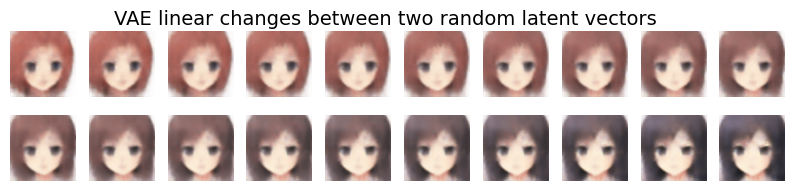

In [34]:
def interpolate_points(p1, p2, n_steps=10):
    # Compute the linearly interpolated vectors
    # create a linspace with n_steps elements between 0 and 1
    ratios = np.linspace(0, 1, num=n_steps)
    vectors = list()
    for ratio in ratios:
        # implement the interpolation formula
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    vectors = np.asarray(vectors)  # make the vectors a numpy array
    # return the reshaped vectors array in accordance with the input required by the decoder
    return vectors.reshape(vectors.shape[0], latent_dim)

## define a function to plot the changes in the latent space
def flexible_grid_plot(
    images,
    x,
    y,
    name="",
    save=False,
    scale=False,
    method="",
    show=True,
):
    if scale:
        images = (images + 1) / 2.0

    plt.figure(figsize=(y, x))

    for index in range(x * y):
        plt.subplot(x, y, 1 + index)
        plt.axis("off")
        if index < len(images):  # Only plot if there's an image left to plot
            plt.imshow(images[index])
        else:
            plt.axis("off")  # Turn off axes for any remaining subplots

    fig = plt.gcf()
    fig.suptitle(name, fontsize=14)

    if save:
        filedir = "drive/MyDrive"
        filename = f"{method}_output_changes.png"
        plt.savefig(filedir + filename)
        plt.close()
    if show:
        plt.show()


# 1. Generate two random latent vectors
point1 = np.random.randn(1, latent_dim)
point2 = np.random.randn(1, latent_dim)

# 2. Linearly interpolate between the two points
interpolated = interpolate_points(point1, point2, n_steps=20)

# 3. Decode the interpolated vectors to generate images
interpolated_images = decoder(interpolated)

# 4. Visualize the generated images
flexible_grid_plot(
    interpolated_images,
    x=2,
    y=10,
    name="VAE linear changes between two random latent vectors",
)

## Generative Adversarial Networks (GANs)

In [24]:
def build_gan(data_shape, latent_dim, filters=128, lr=0.0002, beta_1=0.5):
    #optimizer = tf.optimizers.Adam(learning_rate=lr, beta_1=beta_1)
    # have to change the optimizer to aviod bugs
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, beta_1=beta_1)

    # Usually thew GAN generator has tanh activation function in the output layer
    generator = build_deconv_net(latent_dim, activation_out="tanh", filters=filters)

    # Build and compile the discriminator
    discriminator = build_conv_net(
        in_shape=data_shape, out_shape=1, filters=filters
    )  # Single output for binary classification
    discriminator.compile(loss="binary_crossentropy", optimizer=optimizer)

    # End-to-end GAN model for training the generator
    discriminator.trainable = False
    true_fake_prediction = discriminator(generator.output)
    GAN = tf.keras.Model(inputs=generator.input, outputs=true_fake_prediction)
    GAN = tf.keras.models.Sequential([generator, discriminator])
    GAN.compile(loss="binary_crossentropy", optimizer=optimizer)

    return discriminator, generator, GAN

In [25]:
def run_generator(generator, n_samples=100):
    """
    Run the generator model and generate n samples of synthetic images using random latent vectors
    """
    latent_dim = generator.layers[0].input_shape[-1]
    generator_input = np.random.randn(n_samples, latent_dim)

    return generator.predict(generator_input)


def get_batch(generator, dataset, batch_size=64):
    """
    Gets a single batch of samples (X) and labels (y) for the training the discriminator.
    One half from the real dataset (labeled as 1s), the other created by the generator model (labeled as 0s).
    """
    batch_size //= 2  # Split evenly among fake and real samples

    fake_data = run_generator(generator, n_samples=batch_size)
    real_data = dataset[np.random.randint(0, dataset.shape[0], batch_size)]

    X = np.concatenate([fake_data, real_data], axis=0)
    y = np.concatenate([np.zeros([batch_size, 1]), np.ones([batch_size, 1])], axis=0)

    return X, y


def train_gan(
    generator, discriminator, gan, dataset, latent_dim, n_epochs=20, batch_size=64
):
    batches_per_epoch = int(dataset.shape[0] / batch_size / 2)
    for epoch in range(n_epochs):
        for batch in tqdm(range(batches_per_epoch)):
            # 1) Train discriminator both on real and synthesized images
            X, y = get_batch(generator, dataset, batch_size=batch_size)
            discriminator_loss = discriminator.train_on_batch(X, y)

            # 2) Train generator (note that now the label of synthetic images is reversed to 1)
            X_gan = np.random.randn(batch_size, latent_dim)
            y_gan = np.ones([batch_size, 1])
            generator_loss = gan.train_on_batch(X_gan, y_gan)

        noise = np.random.randn(16, latent_dim)
        images = generator.predict(noise)
        grid_plot(
            images, epoch, name="GAN generated images", n=3, save=True, scale=True, method = 'GAN', figtype= 'generated', show=True
        )

In [26]:
# Build and train the model (need around 10 epochs to start seeing some results)

latent_dim = 512
discriminator, generator, gan = build_gan(dataset.shape[1:], latent_dim, filters=128)
dataset_scaled = load_real_samples(scale=True)

train_gan(generator, discriminator, gan, dataset_scaled, latent_dim, n_epochs=200)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1024)              525312    
                                                                 
 reshape_5 (Reshape)         (None, 4, 4, 64)          0         
                                                                 
 conv2d_transpose_20 (Conv2  (None, 8, 8, 128)         73856     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_21 (Conv2  (None, 16, 16, 128)       147584    
 DTranspose)                                                     
                                                                 
 conv2d_transpose_22 (Conv2  (None, 32, 32, 128)       147584    
 DTranspose)                                                     
                                                     

  0%|          | 0/78 [00:00<?, ?it/s]WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x788e72c55000> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 136ms/step


  1%|▏         | 1/78 [00:03<04:08,  3.23s/it]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/78 [00:03<01:47,  1.41s/it]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:03<01:02,  1.20it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:03<00:41,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/78 [00:03<00:29,  2.45it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:03<00:22,  3.15it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:04<00:18,  3.85it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:04<00:15,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:04<00:13,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 10/78 [00:04<00:12,  5.57it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:04<00:11,  5.99it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:04<00:10,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:04<00:09,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:05<00:09,  6.82it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:05<00:08,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:05<00:08,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:05<00:08,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:05<00:08,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:05<00:08,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 20/78 [00:05<00:08,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:06<00:08,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:06<00:07,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:06<00:07,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:06<00:07,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:06<00:07,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:06<00:07,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:06<00:07,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:06<00:07,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:07<00:06,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:07<00:06,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:07<00:06,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:07<00:06,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:07<00:06,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:07<00:06,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:07<00:05,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:08<00:05,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:08<00:05,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:08<00:05,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:08<00:05,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:08<00:05,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:08<00:05,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:08<00:04,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:09<00:04,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:09<00:04,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:09<00:04,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:09<00:04,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:09<00:04,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:09<00:04,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:09<00:03,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:10<00:03,  7.34it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:10<00:03,  7.35it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:10<00:03,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:10<00:03,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:10<00:03,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:10<00:03,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:10<00:03,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:10<00:02,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:11<00:02,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:11<00:02,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:11<00:02,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:11<00:02,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:11<00:02,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:11<00:02,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:11<00:01,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:12<00:01,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:12<00:01,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:12<00:01,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:12<00:01,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:12<00:01,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:12<00:01,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:12<00:00,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:13<00:00,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:13<00:00,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 74/78 [00:13<00:00,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 75/78 [00:13<00:00,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:13<00:00,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:13<00:00,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


1/1 [==============================] - 0s 322ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:10,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:03<00:08,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.07it/s]

1/1 [==============================] - 0s 20ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.35it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.36it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.34it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:09,  7.34it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:10,  6.87it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.51it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 11/78 [00:01<00:10,  6.28it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 12/78 [00:01<00:10,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 13/78 [00:01<00:10,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.61it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.63it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 16/78 [00:02<00:09,  6.35it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 17/78 [00:02<00:09,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:09,  6.52it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 24/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:04<00:06,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.34it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:05,  7.39it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:05<00:05,  7.41it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.38it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.41it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.38it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:06<00:04,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 32/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.92it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.86it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.66it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 4/78 [00:00<00:11,  6.70it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.73it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.81it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/78 [00:01<00:10,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.76it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.86it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 16/78 [00:02<00:08,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.89it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.77it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.78it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.76it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.71it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.76it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 24/78 [00:03<00:07,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.78it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.82it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 32/78 [00:04<00:06,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.76it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:08<00:02,  7.40it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.26it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.37it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.35it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.38it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.40it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:08,  7.38it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 16/78 [00:02<00:09,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 17/78 [00:02<00:09,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:03,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.35it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 78/78 [00:10<00:00,  7.14it/s]


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 78/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:08,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:06,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.35it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:03<00:06,  7.37it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.39it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.36it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:04<00:05,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.34it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:05<00:04,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:07<00:02,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:08<00:01,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:09<00:00,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.74it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:11,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.92it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 8/78 [00:01<00:10,  6.48it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.66it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.93it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:03<00:07,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:06,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.77it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 4/78 [00:00<00:11,  6.71it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.67it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.70it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.71it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 8/78 [00:01<00:10,  6.70it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.78it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.79it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.86it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 16/78 [00:02<00:08,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 24/78 [00:03<00:08,  6.69it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.70it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.66it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.70it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.24it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:11<00:00,  6.97it/s]

1/1 [==============================] - 0s 17ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.34it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.26it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.34it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.35it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.22it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.35it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.34it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:06,  7.39it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:03<00:06,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:04<00:05,  7.39it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:05<00:04,  7.22it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:08<00:01,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:09<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:10<00:00,  7.22it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.46it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.20it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.32it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.35it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.39it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.34it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.37it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:03,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.35it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.34it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.43it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:07,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:06,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.35it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.35it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.34it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:04<00:05,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:05<00:04,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.26it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 49/78 [00:06<00:03,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:02,  7.34it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.73it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.70it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.66it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 4/78 [00:00<00:11,  6.65it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.72it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.74it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/78 [00:01<00:10,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.66it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 11/78 [00:01<00:10,  6.65it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.65it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.69it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 16/78 [00:02<00:09,  6.73it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 17/78 [00:02<00:09,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.81it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.64it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.60it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.62it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.66it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.73it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 24/78 [00:03<00:07,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 27/78 [00:04<00:07,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.76it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.76it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 34/78 [00:05<00:06,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:06<00:05,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.95it/s]

1/1 [==============================] - 0s 17ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.38it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.37it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.27it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.34it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:08,  7.36it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.37it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:04<00:05,  7.08it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.34it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.34it/s]

1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.39it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:05<00:04,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.23it/s]

1/1 [==============================] - 0s 15ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:03,  7.36it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.41it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.40it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.42it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.38it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:02,  7.35it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.36it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:07<00:02,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:08<00:01,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.25it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:09<00:00,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:10<00:00,  7.25it/s]

1/1 [==============================] - 0s 17ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.35it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.39it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:09,  7.37it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.20it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:07,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.26it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:04<00:05,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:05<00:04,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 57/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 78/78 [00:10<00:00,  7.17it/s]


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.38it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:07,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.34it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.35it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:04<00:05,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:05<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.29it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.34it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.39it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.42it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.40it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.37it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:09<00:00,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.35it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.39it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.41it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.39it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:10<00:00,  7.22it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.45it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.32it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 8/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.26it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.32it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.32it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:04<00:05,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:05<00:04,  7.19it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 17ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/78 [00:01<00:19,  3.77it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 6/78 [00:01<00:16,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/78 [00:01<00:14,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 8/78 [00:01<00:12,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 9/78 [00:01<00:11,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 10/78 [00:01<00:11,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 11/78 [00:01<00:10,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/78 [00:02<00:10,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 13/78 [00:02<00:09,  6.55it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.52it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.60it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 16/78 [00:02<00:09,  6.70it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 17/78 [00:02<00:09,  6.76it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.74it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 19/78 [00:03<00:08,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 20/78 [00:03<00:08,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.82it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 24/78 [00:03<00:08,  6.63it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 25/78 [00:04<00:07,  6.63it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 26/78 [00:04<00:07,  6.77it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 27/78 [00:04<00:07,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.71it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:05<00:06,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:05<00:06,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 34/78 [00:05<00:06,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:06<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:06<00:05,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:06<00:05,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:07<00:04,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:07<00:04,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 53/78 [00:08<00:03,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:08<00:03,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:09<00:02,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:10<00:01,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.76it/s]

1/1 [==============================] - 0s 17ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:04<00:05,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.23it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 43/78 [00:05<00:04,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.41it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.41it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.25it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.36it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.36it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.22it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:05<00:04,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.23it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:10<00:00,  7.10it/s]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 16/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.29it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:05<00:04,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.24it/s]

1/1 [==============================] - 0s 15ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.31it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:03,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.35it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.36it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:10<00:00,  7.18it/s]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.38it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 20/78 [00:03<00:14,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 21/78 [00:03<00:12,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 22/78 [00:03<00:10,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 23/78 [00:03<00:10,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 24/78 [00:03<00:09,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 25/78 [00:03<00:08,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 26/78 [00:04<00:08,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 27/78 [00:04<00:07,  6.38it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.50it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.65it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.49it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 31/78 [00:04<00:07,  6.54it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 32/78 [00:04<00:06,  6.63it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 33/78 [00:05<00:06,  6.71it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 34/78 [00:05<00:06,  6.71it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.69it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.73it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 37/78 [00:05<00:06,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.76it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 40/78 [00:06<00:05,  6.79it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 41/78 [00:06<00:05,  6.71it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.73it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:07<00:04,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.75it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:08<00:03,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 54/78 [00:08<00:03,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.84it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:09<00:02,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 67/78 [00:10<00:01,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:11<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  6.71it/s]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/78 [00:01<00:09,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.89it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.35it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.44it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.42it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 43/78 [00:05<00:04,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.42it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.39it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 16/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.05it/s]

1/1 [==============================] - 0s 20ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 24/78 [00:03<00:07,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.24it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.27it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.23it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.34it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.33it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.37it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.37it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.34it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.20it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:08,  7.36it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 25/78 [00:03<00:12,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 26/78 [00:03<00:10,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 27/78 [00:04<00:09,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 28/78 [00:04<00:08,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 29/78 [00:04<00:08,  6.00it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 31/78 [00:04<00:07,  6.49it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 32/78 [00:04<00:07,  6.55it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.69it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 34/78 [00:05<00:06,  6.68it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.63it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.69it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 37/78 [00:05<00:06,  6.79it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:06<00:05,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.81it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.82it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.25it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.31it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.19it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 8/78 [00:01<00:09,  7.32it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.35it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.40it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.42it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:08,  7.41it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.33it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 16/78 [00:02<00:08,  7.35it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.39it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.35it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:07,  7.34it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.28it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:03<00:06,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.34it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.36it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████      | 32/78 [00:04<00:06,  7.39it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.40it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:04<00:05,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.37it/s]

1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.39it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:05<00:04,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:03,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.34it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.34it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:07<00:02,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:08<00:01,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.27it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.34it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:09<00:00,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:10<00:00,  7.25it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.25it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.37it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:04<00:05,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:05<00:04,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/78 [00:00<00:10,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:07,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.36it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.26it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.27it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.23it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.22it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 21ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.21it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▋         | 5/78 [00:00<00:09,  7.34it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.21it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 39/78 [00:05<00:09,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 40/78 [00:05<00:07,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 41/78 [00:06<00:07,  5.24it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 42/78 [00:06<00:06,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 44/78 [00:06<00:05,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 45/78 [00:06<00:05,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 46/78 [00:06<00:05,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.46it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  6.58it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.58it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.60it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 51/78 [00:07<00:04,  6.66it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.75it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 78/78 [00:11<00:00,  6.82it/s]


1/1 [==============================] - 0s 23ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:03<00:08,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:04<00:07,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:05<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:11<00:00,  7.04it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:08,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.22it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 16/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.06it/s]


1/1 [==============================] - 0s 18ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.07it/s]

1/1 [==============================] - 0s 20ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.38it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.39it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.37it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.35it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:05<00:04,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 45/78 [00:06<00:08,  4.11it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 46/78 [00:06<00:06,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 47/78 [00:06<00:06,  5.09it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 48/78 [00:07<00:05,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 49/78 [00:07<00:05,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.00it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 51/78 [00:07<00:04,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 52/78 [00:07<00:04,  6.48it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.59it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.58it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.64it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.62it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.70it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.76it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 78/78 [00:11<00:00,  6.83it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.85it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.03it/s]

1/1 [==============================] - 0s 21ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:10<00:00,  7.15it/s]


1/1 [==============================] - 0s 25ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.28it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.37it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.37it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  6.88it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.36it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.18it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.12it/s]


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:03,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.94it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.78it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.71it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.68it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.56it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.67it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.65it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.76it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 78/78 [00:11<00:00,  7.01it/s]


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.26it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.20it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.27it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 24/78 [00:03<00:07,  7.29it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.36it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.36it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▎     | 34/78 [00:04<00:05,  7.37it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.39it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 36/78 [00:04<00:05,  7.39it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.42it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:05<00:04,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.37it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.43it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.34it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.31it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.39it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:07<00:02,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 59/78 [00:08<00:04,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 60/78 [00:08<00:03,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 61/78 [00:08<00:03,  5.28it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 63/78 [00:09<00:02,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 65/78 [00:09<00:02,  6.41it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.51it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.59it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.55it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.67it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.72it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.69it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.62it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.66it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 78/78 [00:11<00:00,  6.93it/s]


1/1 [==============================] - 0s 27ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.64it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.75it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/78 [00:00<00:11,  6.65it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.77it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:10,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:03<00:07,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:04<00:06,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:05<00:06,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 78/78 [00:11<00:00,  7.03it/s]


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.33it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.39it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.24it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.40it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.37it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:08,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.07it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.35it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 49/78 [00:06<00:03,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 62/78 [00:09<00:03,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 63/78 [00:09<00:03,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 65/78 [00:09<00:02,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.48it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.62it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.70it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.75it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.58it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.62it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.71it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 78/78 [00:11<00:00,  6.86it/s]


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/78 [00:01<00:10,  6.75it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:02<00:09,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.84it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 35/78 [00:05<00:06,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.04it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:11<00:00,  7.06it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/78 [00:01<00:09,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:04<00:05,  7.38it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:05<00:04,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:08<00:02,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.87it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 20ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.67it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.07it/s]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.76it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 78/78 [00:11<00:00,  6.88it/s]


1/1 [==============================] - 0s 24ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 8/78 [00:01<00:10,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.67it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.75it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 16/78 [00:02<00:09,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:04<00:07,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 32/78 [00:04<00:06,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:05,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  6.96it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:01<00:10,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.07it/s]


1/1 [==============================] - 0s 27ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:10,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:02<00:09,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:03,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 16/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.06it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 24/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 32/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 17ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.84it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/78 [00:01<00:10,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 17/78 [00:02<00:09,  6.65it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 18/78 [00:02<00:09,  6.65it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.74it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.76it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.68it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.64it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.61it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.64it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.62it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.64it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.66it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.76it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 31/78 [00:04<00:07,  6.67it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 34/78 [00:05<00:06,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:06<00:05,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.91it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 78/78 [00:11<00:00,  6.92it/s]


1/1 [==============================] - 0s 18ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/78 [00:01<00:10,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 32/78 [00:04<00:06,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.76it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:05,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 78/78 [00:11<00:00,  7.01it/s]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/78 [00:00<00:10,  6.83it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 8/78 [00:01<00:10,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.25it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.31it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.40it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.09it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.23it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.76it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  7.04it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.71it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.77it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.70it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.74it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.76it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.73it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/78 [00:01<00:10,  6.67it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.74it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.71it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.73it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.75it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.70it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 16/78 [00:02<00:09,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.88it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 24/78 [00:03<00:07,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 32/78 [00:04<00:06,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.68it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.69it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 78/78 [00:11<00:00,  6.95it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.87it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/78 [00:01<00:10,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.85it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:03<00:08,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.03it/s]


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 7/78 [00:00<00:10,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 32/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.26it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  7.06it/s]

1/1 [==============================] - 0s 24ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.40it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.34it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 78/78 [00:10<00:00,  7.14it/s]


1/1 [==============================] - 0s 18ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:03<00:08,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 24/78 [00:03<00:07,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:04<00:07,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:05<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.03it/s]

1/1 [==============================] - 0s 21ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.94it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.68it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.75it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.74it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.68it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.75it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/78 [00:01<00:10,  6.65it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.70it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.58it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 11/78 [00:01<00:10,  6.60it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.63it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.65it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.68it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.64it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 16/78 [00:02<00:09,  6.62it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 17/78 [00:02<00:09,  6.64it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.70it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.68it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 20/78 [00:03<00:08,  6.53it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.49it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.63it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.71it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 24/78 [00:03<00:08,  6.64it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.69it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:04<00:07,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.81it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 34/78 [00:05<00:06,  6.76it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 41/78 [00:06<00:05,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:08<00:03,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.94it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.21it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:08,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 24/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.91it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.87it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  7.08it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.38it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.93it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 21/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 24/78 [00:03<00:07,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.92it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.94it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.95it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.03it/s]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.25it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 23ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 16/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 24/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.88it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 51/78 [00:07<00:04,  6.70it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.65it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  7.02it/s]


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.93it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.81it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 4/78 [00:00<00:11,  6.71it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/78 [00:00<00:11,  6.60it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.64it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.69it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/78 [00:01<00:10,  6.75it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 16/78 [00:02<00:09,  6.64it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 17/78 [00:02<00:09,  6.65it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.69it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.64it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.73it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 32/78 [00:04<00:06,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 34/78 [00:05<00:06,  6.76it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.65it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.70it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 37/78 [00:05<00:06,  6.61it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:06<00:05,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.93it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:08<00:03,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.25it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 78/78 [00:11<00:00,  6.93it/s]

1/1 [==============================] - 0s 20ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.32it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:05<00:04,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 78/78 [00:10<00:00,  7.12it/s]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 16/78 [00:02<00:08,  6.94it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.86it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 32/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.83it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.97it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:02<00:09,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.25it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.25it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.96it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.24it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.86it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 78/78 [00:10<00:00,  7.09it/s]


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.86it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.99it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.00it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:02<00:09,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 20/78 [00:03<00:14,  4.08it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 21/78 [00:03<00:12,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 22/78 [00:03<00:10,  5.10it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 23/78 [00:03<00:10,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 24/78 [00:03<00:09,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 25/78 [00:03<00:08,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 26/78 [00:04<00:08,  6.31it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 27/78 [00:04<00:07,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.54it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.55it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.56it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 31/78 [00:04<00:07,  6.65it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 32/78 [00:04<00:06,  6.74it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 33/78 [00:05<00:06,  6.79it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 34/78 [00:05<00:06,  6.84it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.68it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 39/78 [00:06<00:05,  6.73it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 40/78 [00:06<00:05,  6.70it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 41/78 [00:06<00:05,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.83it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 46/78 [00:07<00:04,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 47/78 [00:07<00:04,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.84it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:08<00:03,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:08<00:03,  6.94it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.95it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.82it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 60/78 [00:09<00:02,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:10<00:01,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:11<00:00,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 78/78 [00:11<00:00,  6.74it/s]


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:10,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/78 [00:01<00:09,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.90it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 16/78 [00:02<00:09,  6.76it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.91it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.21it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 24/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.87it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.08it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:10,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.80it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.91it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.80it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:09,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 24/78 [00:03<00:07,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:04<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 32/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 35/78 [00:05<00:06,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.95it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.86it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  7.00it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.85it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 78/78 [00:11<00:00,  6.94it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.99it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.91it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.86it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 16/78 [00:02<00:09,  6.77it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 17/78 [00:02<00:09,  6.71it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.77it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:08,  6.71it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.86it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.87it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.68it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:04,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:11<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 78/78 [00:11<00:00,  7.04it/s]


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  6.97it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.86it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:03<00:08,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 24/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 26/78 [00:04<00:12,  4.08it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 27/78 [00:04<00:11,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 28/78 [00:04<00:09,  5.10it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 29/78 [00:04<00:08,  5.47it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 30/78 [00:04<00:08,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 31/78 [00:04<00:07,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 32/78 [00:04<00:07,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 33/78 [00:05<00:07,  6.39it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 34/78 [00:05<00:06,  6.50it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.49it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.58it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 37/78 [00:05<00:06,  6.65it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.70it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 39/78 [00:06<00:05,  6.55it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 40/78 [00:06<00:05,  6.57it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 41/78 [00:06<00:05,  6.64it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.72it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.76it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 44/78 [00:06<00:05,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.68it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 46/78 [00:07<00:04,  6.75it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 47/78 [00:07<00:04,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  6.83it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.67it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.68it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.80it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:08<00:03,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 54/78 [00:08<00:03,  6.73it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.76it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:09<00:02,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.93it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 67/78 [00:10<00:01,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 74/78 [00:11<00:00,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.98it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.68it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.34it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:09,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.25it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.15it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 78/78 [00:10<00:00,  7.10it/s]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.16it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 8/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.71it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.79it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  7.02it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 24/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.24it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.88it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:11<00:00,  7.09it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.41it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 32/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.28it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 64/78 [00:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.72it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.61it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  7.08it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 21/78 [00:02<00:08,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.91it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 23/78 [00:03<00:13,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 24/78 [00:03<00:11,  4.54it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 25/78 [00:03<00:10,  5.05it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 26/78 [00:04<00:09,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 27/78 [00:04<00:08,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 28/78 [00:04<00:08,  6.09it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.28it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.41it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 31/78 [00:04<00:07,  6.52it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 32/78 [00:04<00:07,  6.50it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 33/78 [00:05<00:06,  6.65it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 34/78 [00:05<00:06,  6.75it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.66it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.60it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 37/78 [00:05<00:06,  6.51it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 38/78 [00:05<00:06,  6.49it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 39/78 [00:06<00:05,  6.64it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 40/78 [00:06<00:05,  6.77it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 41/78 [00:06<00:05,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.71it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.76it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 44/78 [00:06<00:05,  6.71it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.70it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 46/78 [00:07<00:04,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 47/78 [00:07<00:04,  6.74it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:08<00:03,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 54/78 [00:08<00:03,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.98it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:09<00:02,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.08it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:10<00:01,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.78it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.67it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:11<00:00,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.69it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.15it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 8/78 [00:01<00:10,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.26it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.26it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.24it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:10,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 24/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.19it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.99it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.94it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.05it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/78 [00:01<00:10,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:03<00:08,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.07it/s]

1/1 [==============================] - 0s 20ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.90it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 24/78 [00:03<00:07,  6.84it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.24it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  7.08it/s]


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.22it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.96it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 16/78 [00:02<00:08,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 21/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 24/78 [00:03<00:07,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 32/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.79it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 37/78 [00:05<00:10,  3.92it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 38/78 [00:05<00:08,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 39/78 [00:05<00:07,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 40/78 [00:06<00:07,  5.36it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 41/78 [00:06<00:06,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 42/78 [00:06<00:06,  5.95it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 44/78 [00:06<00:05,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 45/78 [00:06<00:05,  6.49it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 46/78 [00:07<00:04,  6.45it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 47/78 [00:07<00:04,  6.55it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  6.59it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.60it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.72it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.78it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.66it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 53/78 [00:08<00:03,  6.65it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 54/78 [00:08<00:03,  6.75it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.81it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.62it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.67it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 58/78 [00:08<00:03,  6.65it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.70it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 60/78 [00:09<00:02,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.78it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.87it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.74it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 67/78 [00:10<00:01,  6.82it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:11<00:00,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.92it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 78/78 [00:11<00:00,  6.67it/s]

1/1 [==============================] - 0s 20ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.85it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/78 [00:01<00:10,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:03<00:08,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.21it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/78 [00:01<00:10,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 16/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:03<00:08,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.98it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  7.04it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 8/78 [00:01<00:10,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 16/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.84it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.72it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 44/78 [00:06<00:05,  6.72it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:11<00:00,  7.02it/s]

1/1 [==============================] - 0s 20ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/78 [00:01<00:10,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.23it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.90it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.90it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 78/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.35it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:07,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.97it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.92it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 53/78 [00:07<00:06,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 54/78 [00:07<00:05,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 55/78 [00:08<00:04,  5.01it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 56/78 [00:08<00:04,  5.35it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 58/78 [00:08<00:03,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 59/78 [00:08<00:03,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.24it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 65/78 [00:09<00:02,  6.39it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.54it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.62it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  6.61it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.69it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.66it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.70it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.64it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.53it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.65it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  6.57it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.58it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.65it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 78/78 [00:11<00:00,  6.72it/s]


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/78 [00:01<00:10,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 16/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 24/78 [00:03<00:07,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 37/78 [00:05<00:06,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.75it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.74it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.68it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  6.94it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/78 [00:00<00:09,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.37it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.36it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.34it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.38it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.20it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 24/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 32/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:05<00:04,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.93it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:08<00:02,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.67it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.62it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.81it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.09it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:09,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 32/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.73it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.64it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  6.98it/s]


1/1 [==============================] - 0s 27ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:10,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:02<00:09,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.34it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.20it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 78/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.86it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 32/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.06it/s]


1/1 [==============================] - 0s 22ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.90it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.37it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.51it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/78 [00:00<00:11,  6.61it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/78 [00:00<00:11,  6.51it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.64it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.69it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 8/78 [00:01<00:10,  6.67it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.70it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.73it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.70it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.62it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.61it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.51it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 16/78 [00:02<00:09,  6.50it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 17/78 [00:02<00:09,  6.54it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 18/78 [00:02<00:09,  6.57it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.62it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 20/78 [00:03<00:08,  6.70it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 24/78 [00:03<00:08,  6.66it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.68it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 27/78 [00:04<00:07,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.85it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 34/78 [00:05<00:06,  6.84it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.98it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:06<00:05,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:08<00:03,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  6.92it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 16/78 [00:02<00:08,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.77it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  6.88it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.17it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.09it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 32/78 [00:04<00:06,  6.69it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.69it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.68it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.01it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/78 [00:00<00:11,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 16/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 21/78 [00:02<00:08,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.93it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 32/78 [00:04<00:06,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.97it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:06,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:11<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:10,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:10,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 78/78 [00:11<00:00,  7.03it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.57it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.67it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.67it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 4/78 [00:00<00:11,  6.72it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/78 [00:00<00:11,  6.58it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.57it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.54it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 8/78 [00:01<00:10,  6.59it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.61it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.68it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 11/78 [00:01<00:10,  6.68it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.69it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.73it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.80it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 16/78 [00:02<00:09,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 17/78 [00:02<00:09,  6.76it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.79it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.77it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 24/78 [00:03<00:07,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 27/78 [00:04<00:07,  6.74it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.67it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.80it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 31/78 [00:04<00:07,  6.63it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 32/78 [00:04<00:06,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:05<00:06,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.77it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 37/78 [00:05<00:06,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.88it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 41/78 [00:06<00:05,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.94it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:11<00:00,  6.90it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.38it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.37it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 32/78 [00:04<00:06,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.74it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.79it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.76it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.94it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.30it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.92it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.99it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.76it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.76it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.76it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.84it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.24it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.88it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.78it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 22ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.64it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.43it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.58it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 4/78 [00:00<00:11,  6.68it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.73it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.77it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/78 [00:01<00:10,  6.80it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.81it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.78it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 11/78 [00:01<00:10,  6.61it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 12/78 [00:01<00:10,  6.52it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.59it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.56it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.66it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 16/78 [00:02<00:09,  6.70it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 17/78 [00:02<00:09,  6.72it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.76it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.86it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.83it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.66it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.71it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.74it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 24/78 [00:03<00:07,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:04<00:07,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.90it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.60it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 31/78 [00:04<00:07,  6.66it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 32/78 [00:04<00:06,  6.63it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.71it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 34/78 [00:05<00:06,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 37/78 [00:05<00:06,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 41/78 [00:06<00:05,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  7.20it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  6.88it/s]


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.77it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/78 [00:01<00:10,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.21it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.25it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.30it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.77it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.87it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.97it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 8/78 [00:01<00:10,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  7.05it/s]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.88it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.77it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 8/78 [00:01<00:10,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 24/78 [00:03<00:07,  6.88it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:04<00:07,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:05<00:06,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.76it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.02it/s]


1/1 [==============================] - 0s 18ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.78it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.24it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.25it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.24it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 49/78 [00:06<00:03,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.34it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:07<00:03,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:10<00:00,  7.16it/s]


1/1 [==============================] - 0s 23ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.55it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.41it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.61it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 4/78 [00:00<00:11,  6.70it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.75it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.80it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 8/78 [00:01<00:10,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.70it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.75it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.83it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.83it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.77it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.77it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.84it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 16/78 [00:02<00:09,  6.73it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 18/78 [00:02<00:09,  6.59it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.56it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.57it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.53it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.66it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.72it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 24/78 [00:03<00:07,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.73it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.83it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.69it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 32/78 [00:04<00:06,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 34/78 [00:05<00:06,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.78it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.83it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 41/78 [00:06<00:05,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.82it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.85it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 55/78 [00:08<00:03,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.88it/s]


1/1 [==============================] - 0s 18ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.87it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 16/78 [00:02<00:09,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 24/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.71it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:11<00:00,  7.05it/s]

1/1 [==============================] - 0s 21ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.36it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.26it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.34it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.16it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████      | 32/78 [00:04<00:06,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.84it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.72it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 51/78 [00:07<00:04,  6.64it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.09it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  6.99it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 8/78 [00:01<00:10,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:03<00:08,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.90it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.86it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 78/78 [00:11<00:00,  7.01it/s]

1/1 [==============================] - 0s 17ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 24/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 32/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.88it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.89it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.65it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.67it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.73it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  7.03it/s]


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.69it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.81it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.78it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 4/78 [00:00<00:11,  6.71it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.72it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.69it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/78 [00:01<00:10,  6.64it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.68it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.75it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.81it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.81it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.72it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.64it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 16/78 [00:02<00:09,  6.67it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 17/78 [00:02<00:09,  6.69it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.69it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.69it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.75it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 24/78 [00:03<00:08,  6.66it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.70it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.69it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 27/78 [00:04<00:07,  6.79it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.85it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 34/78 [00:05<00:06,  6.75it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:06<00:05,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.66it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.67it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.85it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/78 [00:00<00:10,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 16/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.95it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.89it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.76it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:10,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/78 [00:02<00:09,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.82it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.87it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 78/78 [00:11<00:00,  7.04it/s]


1/1 [==============================] - 0s 26ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/78 [00:01<00:10,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.93it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.88it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:07,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.74it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 32/78 [00:04<00:06,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 36/78 [00:05<00:06,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  6.99it/s]


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.88it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.86it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:10,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/78 [00:02<00:09,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:03<00:08,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.88it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.22it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████      | 32/78 [00:04<00:06,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.35it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.94it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.72it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 78/78 [00:11<00:00,  7.05it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.36it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.25it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 20/78 [00:03<00:14,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 21/78 [00:03<00:12,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 22/78 [00:03<00:11,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 23/78 [00:03<00:10,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 24/78 [00:03<00:09,  5.74it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 25/78 [00:03<00:08,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 26/78 [00:04<00:08,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 27/78 [00:04<00:07,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.52it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.67it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.63it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 31/78 [00:04<00:07,  6.69it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 32/78 [00:04<00:06,  6.76it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 33/78 [00:05<00:06,  6.82it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 34/78 [00:05<00:06,  6.68it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 39/78 [00:06<00:05,  6.74it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 40/78 [00:06<00:05,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 41/78 [00:06<00:05,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.92it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 46/78 [00:07<00:04,  6.84it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 47/78 [00:07<00:04,  6.74it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  6.72it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.60it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.65it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.84it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 53/78 [00:08<00:03,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 54/78 [00:08<00:03,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:09<00:02,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:10<00:01,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  6.88it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 74/78 [00:11<00:00,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  6.68it/s]


1/1 [==============================] - 0s 18ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 14/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.65it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 16/78 [00:02<00:09,  6.50it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 17/78 [00:02<00:09,  6.41it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 18/78 [00:02<00:09,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.61it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.52it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.59it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.72it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:04<00:07,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:05<00:06,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.23it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 78/78 [00:11<00:00,  7.01it/s]

1/1 [==============================] - 0s 17ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.35it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.43it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.20it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.21it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:05<00:04,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.16it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.21it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 24/78 [00:03<00:07,  6.93it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.82it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 32/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.77it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.71it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.70it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.71it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:05,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.93it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 78/78 [00:11<00:00,  7.02it/s]

1/1 [==============================] - 0s 21ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  6.90it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.82it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.86it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.85it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.91it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.82it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.84it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.74it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.62it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.99it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.37it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.49it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.47it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 25/78 [00:03<00:13,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 26/78 [00:04<00:11,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 27/78 [00:04<00:10,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 28/78 [00:04<00:09,  5.43it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 29/78 [00:04<00:08,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 31/78 [00:04<00:07,  6.16it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 32/78 [00:04<00:07,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 33/78 [00:05<00:07,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 34/78 [00:05<00:06,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.55it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 37/78 [00:05<00:06,  6.55it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 38/78 [00:05<00:06,  6.54it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 39/78 [00:06<00:05,  6.50it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 40/78 [00:06<00:05,  6.57it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 41/78 [00:06<00:05,  6.45it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.51it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.57it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 44/78 [00:06<00:05,  6.59it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.60it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 46/78 [00:07<00:04,  6.61it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 47/78 [00:07<00:04,  6.54it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  6.60it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.67it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.70it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 51/78 [00:07<00:04,  6.66it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:08<00:03,  6.71it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 54/78 [00:08<00:03,  6.72it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 60/78 [00:09<00:02,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 67/78 [00:10<00:01,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:11<00:00,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  6.96it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  7.00it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 78/78 [00:11<00:00,  6.65it/s]


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.87it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/78 [00:01<00:10,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.72it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.69it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.84it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 16/78 [00:02<00:09,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.77it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.74it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.83it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.76it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.86it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.90it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.86it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.94it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.78it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.79it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 78/78 [00:11<00:00,  6.91it/s]


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:10,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/78 [00:01<00:09,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 16/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.91it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.80it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.84it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.74it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:06,  6.79it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.74it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.64it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.79it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.70it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.74it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:04,  6.74it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.71it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.69it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.64it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.56it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.61it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 58/78 [00:08<00:03,  6.54it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.58it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.68it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.63it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.57it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.69it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.74it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.90it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.83it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.88it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 78/78 [00:11<00:00,  6.84it/s]


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.84it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.82it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.79it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.77it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 8/78 [00:01<00:10,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.82it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  6.77it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.76it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.81it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.95it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  6.91it/s]


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 16/78 [00:02<00:08,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.94it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.90it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.32it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 24/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.86it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 42/78 [00:06<00:08,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 43/78 [00:06<00:07,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 44/78 [00:06<00:06,  5.20it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 45/78 [00:06<00:05,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 46/78 [00:06<00:05,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 47/78 [00:06<00:05,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.41it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 51/78 [00:07<00:04,  6.36it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 52/78 [00:07<00:04,  6.44it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.55it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 54/78 [00:08<00:03,  6.65it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.55it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.66it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.68it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.63it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  6.65it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.65it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.66it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.67it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.70it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.58it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 67/78 [00:10<00:01,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  6.65it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.74it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.75it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.63it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.68it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:11<00:00,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.64it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.69it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 78/78 [00:11<00:00,  6.70it/s]


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.81it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:02<00:09,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:03<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.88it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  7.04it/s]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.50it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.54it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:11,  6.65it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.65it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.70it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:10,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:02<00:09,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 24/78 [00:03<00:07,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.18it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.33it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.23it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.35it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.38it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.00it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.26it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.31it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.29it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 20ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.77it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.96it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 16/78 [00:02<00:09,  6.85it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:03<00:08,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.38it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.95it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.86it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.05it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.76it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 8/78 [00:01<00:10,  6.54it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.67it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:02<00:09,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.82it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.76it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 24/78 [00:03<00:07,  6.76it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.88it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:07,  7.01it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 35/78 [00:05<00:06,  7.10it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.90it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.83it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.51it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.59it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 44/78 [00:06<00:05,  6.42it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:05,  6.46it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:05,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.27it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 51/78 [00:07<00:04,  6.13it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 52/78 [00:07<00:04,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.25it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.54it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 58/78 [00:08<00:03,  6.15it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 59/78 [00:08<00:03,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  6.52it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.70it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.83it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  7.21it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.79it/s]

1/1 [==============================] - 0s 17ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.89it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:08,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.78it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  6.87it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.86it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.80it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 38/78 [00:05<00:09,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 39/78 [00:05<00:08,  4.53it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 40/78 [00:06<00:07,  5.02it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 41/78 [00:06<00:06,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 42/78 [00:06<00:06,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 44/78 [00:06<00:05,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 45/78 [00:06<00:05,  6.51it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.58it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 47/78 [00:07<00:04,  6.50it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  6.56it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.65it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.73it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 54/78 [00:08<00:03,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.77it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.80it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.90it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.73it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 67/78 [00:10<00:01,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.83it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 78/78 [00:11<00:00,  6.73it/s]


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.85it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.86it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 32/78 [00:04<00:06,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.97it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 78/78 [00:11<00:00,  7.03it/s]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:10,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.95it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 24/78 [00:03<00:07,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.87it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.23it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  7.06it/s]

1/1 [==============================] - 0s 22ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.96it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.22it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 8/78 [00:01<00:09,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 24/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  6.94it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.82it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.94it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.93it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  7.04it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:10,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.77it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.76it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.89it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.77it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 37/78 [00:05<00:06,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.78it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.79it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.90it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.86it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.90it/s]


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:08,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.23it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 43/78 [00:06<00:08,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 44/78 [00:06<00:07,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 45/78 [00:06<00:06,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 46/78 [00:06<00:05,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 47/78 [00:07<00:05,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.45it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 51/78 [00:07<00:04,  6.47it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 52/78 [00:07<00:04,  6.43it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.53it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 54/78 [00:08<00:03,  6.58it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.67it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.61it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.54it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 58/78 [00:08<00:03,  6.54it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.68it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  6.82it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.58it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.55it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.51it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.57it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:10<00:01,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.83it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 74/78 [00:11<00:00,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  6.71it/s]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.73it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.63it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.77it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:01<00:10,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:10,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.88it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:03<00:08,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:05<00:06,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:06,  7.00it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.71it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.93it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.95it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.86it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:01<00:10,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.97it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:02<00:09,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.82it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.69it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.85it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 78/78 [00:11<00:00,  7.06it/s]

1/1 [==============================] - 0s 21ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.85it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:10,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  6.91it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.85it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.79it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.71it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:09,  6.76it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:09,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  6.79it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.84it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.90it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.86it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.69it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.91it/s]


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.74it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:02<00:09,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 15/78 [00:02<00:09,  7.00it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 16/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.87it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:07,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:05<00:06,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.82it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.89it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.91it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.78it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 57/78 [00:08<00:05,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 58/78 [00:08<00:04,  4.52it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 59/78 [00:08<00:03,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 60/78 [00:08<00:03,  5.38it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.08it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.22it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 65/78 [00:09<00:02,  6.32it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 67/78 [00:10<00:01,  6.49it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  6.49it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.54it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.58it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.53it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.57it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.61it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 74/78 [00:11<00:00,  6.60it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 78/78 [00:11<00:00,  6.63it/s]


1/1 [==============================] - 0s 22ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.75it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.49it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.59it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 8/78 [00:01<00:10,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.77it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 16/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 24/78 [00:03<00:07,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.91it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:05<00:06,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.94it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.86it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.97it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.96it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.85it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  6.92it/s]


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:10,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:09,  6.75it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.91it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:04<00:07,  7.04it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.88it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.91it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  6.86it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.61it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.70it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.75it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.91it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.91it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.98it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.93it/s]

1/1 [==============================] - 0s 17ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.90it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 8/78 [00:01<00:10,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.82it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.63it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 16/78 [00:02<00:09,  6.61it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:09,  6.73it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 18/78 [00:02<00:09,  6.64it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.63it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.64it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.68it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.74it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 32/78 [00:04<00:06,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:05<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.88it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.96it/s]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.91it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.96it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:10,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.90it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:09,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.86it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.77it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.76it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.71it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.12it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.01it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.92it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 78/78 [00:11<00:00,  6.96it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:01<00:10,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:07,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.89it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.70it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 51/78 [00:07<00:06,  3.94it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 52/78 [00:07<00:05,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 53/78 [00:07<00:05,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 54/78 [00:08<00:04,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 55/78 [00:08<00:04,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 58/78 [00:08<00:03,  6.36it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.44it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 60/78 [00:09<00:02,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  6.58it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.59it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.71it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.80it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.81it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 67/78 [00:10<00:01,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  6.76it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.69it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.58it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.70it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.79it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 74/78 [00:11<00:00,  6.85it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  6.68it/s]


1/1 [==============================] - 0s 22ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/78 [00:00<00:11,  6.54it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.62it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/78 [00:01<00:10,  6.63it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.67it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 14/78 [00:02<00:09,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 16/78 [00:02<00:08,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 21/78 [00:03<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.87it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 32/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.99it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.95it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.94it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/78 [00:00<00:10,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:10,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.88it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.88it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 24/78 [00:03<00:07,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.98it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.80it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 32/78 [00:04<00:06,  6.74it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.97it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.63it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.62it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.73it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.69it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 44/78 [00:06<00:05,  6.62it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.78it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.78it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.87it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.91it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.98it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.88it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.90it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 78/78 [00:11<00:00,  6.87it/s]


1/1 [==============================] - 0s 18ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.49it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.85it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 16/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.83it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.93it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.82it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.01it/s]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.25it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/78 [00:01<00:10,  6.96it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 32/78 [00:04<00:06,  6.92it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:05<00:06,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.85it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.88it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:04,  6.68it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.69it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.87it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.93it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.88it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:02<00:09,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.86it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.88it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.89it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 56/78 [00:08<00:05,  3.98it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 57/78 [00:08<00:04,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 58/78 [00:08<00:04,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 59/78 [00:08<00:03,  5.25it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 60/78 [00:08<00:03,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.40it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.52it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 65/78 [00:09<00:02,  6.44it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.52it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 67/78 [00:10<00:01,  6.59it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  6.70it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.80it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.73it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.61it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.60it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.58it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 74/78 [00:11<00:00,  6.65it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  6.49it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.54it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.69it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 78/78 [00:11<00:00,  6.68it/s]


1/1 [==============================] - 0s 22ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 16/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 24/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.83it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:07,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:05<00:06,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.02it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:01<00:10,  7.02it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 8/78 [00:01<00:10,  6.90it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:02<00:09,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 16/78 [00:02<00:09,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:03<00:08,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:07,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.98it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.92it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.89it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.95it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.78it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  6.97it/s]


1/1 [==============================] - 0s 25ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 24/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.26it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.86it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.10it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.77it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.95it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.83it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.89it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:11<00:00,  7.03it/s]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.84it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:10,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:02<00:09,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 21/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.99it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.94it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.92it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 78/78 [00:11<00:00,  6.99it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:10,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.90it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:03<00:08,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:07,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.87it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.91it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.88it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 62/78 [00:09<00:03,  4.13it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 63/78 [00:09<00:03,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  5.07it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 65/78 [00:09<00:02,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 66/78 [00:09<00:02,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.32it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.48it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.52it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.60it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 74/78 [00:11<00:00,  6.70it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  6.76it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.69it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.67it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 78/78 [00:11<00:00,  6.71it/s]


1/1 [==============================] - 0s 27ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.54it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.54it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.61it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 4/78 [00:00<00:11,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 5/78 [00:00<00:11,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 6/78 [00:00<00:11,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:01<00:11,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/78 [00:01<00:10,  6.50it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.54it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.59it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:10,  6.69it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:09,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 24/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:07,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.88it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.81it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.91it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.87it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.98it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.08it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.20it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:11<00:00,  6.95it/s]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.47it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.65it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.74it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  6.64it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.97it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 16/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:07,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.87it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.88it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.77it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.95it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  7.00it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:09,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.73it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:03<00:08,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:07,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.91it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:11<00:00,  7.04it/s]

1/1 [==============================] - 0s 16ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:08,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 24/78 [00:03<00:07,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.96it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.70it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.75it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:11<00:00,  7.02it/s]


1/1 [==============================] - 0s 18ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 24/78 [00:03<00:07,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.69it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 56/78 [00:08<00:05,  4.02it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 57/78 [00:08<00:04,  4.57it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 58/78 [00:08<00:03,  5.05it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 59/78 [00:08<00:03,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 60/78 [00:08<00:03,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.60it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.61it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.69it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 67/78 [00:10<00:01,  6.63it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  6.64it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.91it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.82it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 74/78 [00:11<00:00,  6.74it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.79it/s]

1/1 [==============================] - 0s 32ms/step


100%|██████████| 78/78 [00:11<00:00,  6.70it/s]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:02<00:09,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.91it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.78it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.57it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.74it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.64it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:05,  6.67it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:08<00:02,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.00it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.79it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.22it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 16/78 [00:02<00:08,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.92it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.94it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.73it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.81it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.97it/s]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.63it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:01<00:10,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.72it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:10,  6.67it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.91it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.92it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 32/78 [00:04<00:06,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 35/78 [00:05<00:06,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.27it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:11<00:00,  7.01it/s]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.28it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 24/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.75it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.58it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.54it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.61it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.66it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.92it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 78/78 [00:11<00:00,  7.00it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.82it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 32/78 [00:04<00:06,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 51/78 [00:07<00:06,  3.92it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 52/78 [00:07<00:05,  4.50it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 53/78 [00:07<00:05,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 54/78 [00:08<00:04,  5.37it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 55/78 [00:08<00:04,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  5.91it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 58/78 [00:08<00:03,  6.16it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 59/78 [00:08<00:03,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 60/78 [00:09<00:02,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  6.29it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.38it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.48it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.53it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.48it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 67/78 [00:10<00:01,  6.47it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  6.53it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.56it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.50it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.62it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.77it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.78it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 74/78 [00:11<00:00,  6.69it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.70it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 78/78 [00:11<00:00,  6.66it/s]


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 16/78 [00:02<00:08,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.89it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.96it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 24/78 [00:03<00:07,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.25it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.23it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.22it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.70it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.78it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.92it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 78/78 [00:11<00:00,  7.05it/s]

1/1 [==============================] - 0s 17ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.00it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.89it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.76it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.85it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  7.00it/s]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:10,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.15it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:09,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.19it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.91it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.99it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.79it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.12it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 78/78 [00:11<00:00,  7.01it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/78 [00:01<00:10,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.19it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.30it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.35it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.28it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.14it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 78/78 [00:10<00:00,  7.10it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.37it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.12it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.90it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 8/78 [00:01<00:10,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 16/78 [00:02<00:09,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.89it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 24/78 [00:03<00:07,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.71it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.88it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 45/78 [00:06<00:08,  3.96it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 46/78 [00:06<00:07,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 47/78 [00:07<00:06,  5.05it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 48/78 [00:07<00:05,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 49/78 [00:07<00:05,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 51/78 [00:07<00:04,  6.20it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 52/78 [00:07<00:04,  6.27it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 53/78 [00:08<00:03,  6.47it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 54/78 [00:08<00:03,  6.60it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 55/78 [00:08<00:03,  6.47it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.60it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.60it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 58/78 [00:08<00:03,  6.55it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.69it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 60/78 [00:09<00:02,  6.75it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  6.72it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.65it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.62it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.59it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.67it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 67/78 [00:10<00:01,  6.74it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 74/78 [00:11<00:00,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  6.71it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.76it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  6.64it/s]


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.94it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:10,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.69it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.74it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.69it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.93it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.89it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 24/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.96it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 32/78 [00:04<00:06,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:05<00:06,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.15it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.26it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.90it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.19it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.03it/s]


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.07it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:08,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:09,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.68it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.75it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.82it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.84it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:04<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:05<00:06,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.20it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.18it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.11it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.99it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.77it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.68it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.80it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  7.01it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 8/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.00it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.97it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 16/78 [00:02<00:08,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 17/78 [00:02<00:09,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.73it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 20/78 [00:02<00:09,  6.44it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.54it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.64it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:08,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.81it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.72it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  6.74it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:05<00:06,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:11<00:00,  6.94it/s]


1/1 [==============================] - 0s 33ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.29it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:09,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 16/78 [00:02<00:08,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  7.14it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.91it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:07,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.17it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.97it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.12it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.24it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.12it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:08<00:01,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.09it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:09<00:00,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 19ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.33it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:09,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 21/78 [00:02<00:08,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 24/78 [00:03<00:07,  6.75it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.70it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.66it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 31/78 [00:04<00:07,  6.47it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:07,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 33/78 [00:04<00:07,  6.42it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.60it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.73it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.74it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.67it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.64it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.86it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 51/78 [00:07<00:06,  4.01it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 52/78 [00:07<00:05,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 53/78 [00:08<00:04,  5.09it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 54/78 [00:08<00:04,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 55/78 [00:08<00:04,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.30it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 58/78 [00:08<00:03,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.49it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 60/78 [00:09<00:02,  6.47it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 61/78 [00:09<00:02,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  6.47it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.60it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.59it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.52it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 66/78 [00:10<00:01,  6.59it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 67/78 [00:10<00:01,  6.69it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 68/78 [00:10<00:01,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.70it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.60it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.72it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 73/78 [00:11<00:00,  6.80it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 74/78 [00:11<00:00,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:11<00:00,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.99it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 78/78 [00:11<00:00,  6.64it/s]


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.05it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.88it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:02<00:09,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 16/78 [00:02<00:08,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.05it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 24/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:04<00:07,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.12it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.12it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.98it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.78it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.20it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.25it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 78/78 [00:11<00:00,  7.03it/s]

1/1 [==============================] - 0s 17ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.64it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.80it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.82it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.89it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:10,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 14/78 [00:02<00:09,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 16/78 [00:02<00:08,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.89it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 20/78 [00:02<00:08,  6.94it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 22/78 [00:03<00:08,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 24/78 [00:03<00:07,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:05<00:06,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 44/78 [00:06<00:05,  6.77it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.90it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.87it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.70it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.53it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.68it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  6.71it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.74it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.95it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.79it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.84it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.81it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.89it/s]


1/1 [==============================] - 0s 18ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:11,  6.67it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 3/78 [00:00<00:10,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 4/78 [00:00<00:10,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 8/78 [00:01<00:10,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 9/78 [00:01<00:09,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 14/78 [00:02<00:09,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:03<00:08,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 27/78 [00:03<00:07,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  6.94it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 37/78 [00:05<00:06,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.88it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.04it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.94it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:09<00:02,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.83it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.72it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.95it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.95it/s]

1/1 [==============================] - 0s 18ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:09,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.22it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 8/78 [00:01<00:09,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.12it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 11/78 [00:01<00:09,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 16/78 [00:02<00:08,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 20/78 [00:02<00:07,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:07,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 28/78 [00:03<00:06,  7.21it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 32/78 [00:04<00:06,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 33/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 35/78 [00:04<00:05,  7.21it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.33it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.40it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.43it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.38it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:04,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:05<00:04,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.31it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.14it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 49/78 [00:06<00:03,  7.25it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:06<00:03,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:07<00:02,  7.10it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.19it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 63/78 [00:08<00:02,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:08<00:02,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.80it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 71/78 [00:09<00:01,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.73it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.82it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 17ms/step



  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.37it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.00it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 8/78 [00:01<00:09,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 13/78 [00:01<00:09,  6.96it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 14/78 [00:01<00:09,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 16/78 [00:02<00:08,  7.06it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 17/78 [00:02<00:08,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  6.94it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 19/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.86it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 24/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:06,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 30/78 [00:04<00:06,  7.06it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 32/78 [00:04<00:06,  7.00it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.26it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 47/78 [00:06<00:04,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.89it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 50/78 [00:07<00:04,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  6.85it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 57/78 [00:08<00:03,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.02it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  6.95it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  6.89it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 64/78 [00:09<00:02,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  6.92it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.87it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  3.90it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 78/78 [00:11<00:00,  6.76it/s]


1/1 [==============================] - 0s 24ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/78 [00:00<00:12,  6.18it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 2/78 [00:00<00:11,  6.52it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/78 [00:00<00:11,  6.61it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 4/78 [00:00<00:11,  6.51it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 5/78 [00:00<00:11,  6.63it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/78 [00:00<00:10,  6.69it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 7/78 [00:01<00:10,  6.60it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 8/78 [00:01<00:10,  6.75it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 9/78 [00:01<00:10,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 10/78 [00:01<00:10,  6.68it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.74it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 12/78 [00:01<00:09,  6.70it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 13/78 [00:01<00:10,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 14/78 [00:02<00:10,  6.39it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 15/78 [00:02<00:09,  6.48it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 16/78 [00:02<00:09,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 17/78 [00:02<00:09,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 18/78 [00:02<00:09,  6.61it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 19/78 [00:02<00:09,  6.54it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 20/78 [00:03<00:08,  6.71it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 21/78 [00:03<00:08,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 22/78 [00:03<00:08,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 23/78 [00:03<00:08,  6.75it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 24/78 [00:03<00:07,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 25/78 [00:03<00:07,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 26/78 [00:03<00:07,  6.71it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 27/78 [00:04<00:07,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 28/78 [00:04<00:07,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:07,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.93it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 32/78 [00:04<00:06,  6.59it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.54it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 34/78 [00:05<00:06,  6.73it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 35/78 [00:05<00:06,  6.74it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 36/78 [00:05<00:06,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 37/78 [00:05<00:05,  6.95it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 38/78 [00:05<00:05,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 39/78 [00:05<00:05,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 41/78 [00:06<00:05,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 42/78 [00:06<00:05,  6.69it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 43/78 [00:06<00:05,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 44/78 [00:06<00:05,  6.77it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.86it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:07<00:04,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 48/78 [00:07<00:04,  6.92it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 49/78 [00:07<00:04,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 55/78 [00:08<00:03,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 56/78 [00:08<00:03,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.23it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.31it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:09<00:02,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 63/78 [00:09<00:02,  7.06it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:10<00:01,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 70/78 [00:10<00:01,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 71/78 [00:10<00:01,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  6.88it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  6.99it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 76/78 [00:11<00:00,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 77/78 [00:11<00:00,  7.16it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 78/78 [00:11<00:00,  6.86it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/78 [00:00<00:10,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/78 [00:00<00:10,  7.33it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 3/78 [00:00<00:10,  7.08it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 4/78 [00:00<00:10,  7.23it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 5/78 [00:00<00:10,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 6/78 [00:00<00:10,  7.14it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 7/78 [00:00<00:09,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 8/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 9/78 [00:01<00:09,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 10/78 [00:01<00:09,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 11/78 [00:01<00:09,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 12/78 [00:01<00:09,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 13/78 [00:01<00:09,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 14/78 [00:01<00:09,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 15/78 [00:02<00:08,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 16/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 17/78 [00:02<00:08,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 18/78 [00:02<00:08,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 19/78 [00:02<00:08,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 20/78 [00:02<00:08,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 21/78 [00:02<00:08,  7.09it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 22/78 [00:03<00:07,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 23/78 [00:03<00:07,  7.11it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 24/78 [00:03<00:07,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 25/78 [00:03<00:07,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 26/78 [00:03<00:07,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 27/78 [00:03<00:07,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 28/78 [00:03<00:07,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 29/78 [00:04<00:07,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 30/78 [00:04<00:06,  6.97it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 31/78 [00:04<00:06,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 32/78 [00:04<00:06,  6.83it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 33/78 [00:04<00:06,  6.99it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 34/78 [00:04<00:06,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 35/78 [00:04<00:06,  7.16it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 36/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 37/78 [00:05<00:05,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 38/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 39/78 [00:05<00:05,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 40/78 [00:05<00:05,  7.16it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 41/78 [00:05<00:05,  7.05it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 42/78 [00:05<00:05,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 43/78 [00:06<00:04,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 44/78 [00:06<00:04,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 45/78 [00:06<00:04,  7.22it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 46/78 [00:06<00:04,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 47/78 [00:06<00:04,  6.84it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 48/78 [00:06<00:04,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 49/78 [00:06<00:04,  6.92it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 50/78 [00:07<00:03,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 51/78 [00:07<00:03,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 52/78 [00:07<00:03,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 53/78 [00:07<00:03,  7.02it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 54/78 [00:07<00:03,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 55/78 [00:07<00:03,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 56/78 [00:07<00:03,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 57/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 58/78 [00:08<00:02,  7.07it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 59/78 [00:08<00:02,  7.09it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 60/78 [00:08<00:02,  7.21it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 61/78 [00:08<00:02,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 62/78 [00:08<00:02,  7.25it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 63/78 [00:08<00:02,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 64/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 65/78 [00:09<00:01,  7.24it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 66/78 [00:09<00:01,  7.07it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 67/78 [00:09<00:01,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 68/78 [00:09<00:01,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 69/78 [00:09<00:01,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 70/78 [00:09<00:01,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 71/78 [00:10<00:00,  7.18it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 72/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 73/78 [00:10<00:00,  7.02it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 74/78 [00:10<00:00,  6.91it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 75/78 [00:10<00:00,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 76/78 [00:10<00:00,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 77/78 [00:10<00:00,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 78/78 [00:11<00:00,  7.07it/s]


1/1 [==============================] - 0s 26ms/step


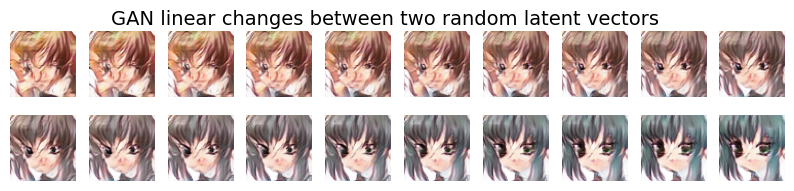

In [38]:
# 1. Generate two random latent vectors
point1 = np.random.randn(1, latent_dim)
point2 = np.random.randn(1, latent_dim)

# 2. Linearly interpolate between the two points
interpolated = interpolate_points(point1, point2, n_steps=20)

# 3. Decode the interpolated vectors to generate images
interpolated_images = generator(interpolated)

# 4. Visualize the generated images
flexible_grid_plot(
    interpolated_images,
    x=2,
    y=10,
    name="GAN linear changes between two random latent vectors",scale = True
)